## Assumptions
- Passing face image to this
    - Reason: validate_locations size of the image assuming that eyes are above half of the face

## Initialise MediaPipe Face Mesh

In [148]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# Initialize MediaPipe Drawing Utils
mp_drawing = mp.solutions.drawing_utils

# Read and Process the Image
image_path = '../../dataset/invalid/hair_cross-1.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

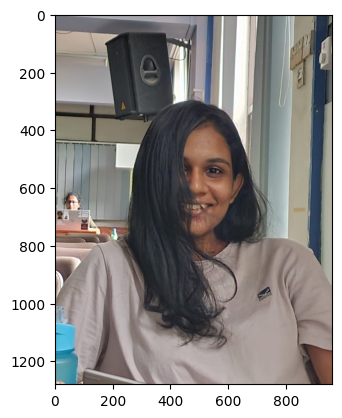

(1280, 960, 3)


In [176]:
plt.imshow(image_rgb)
# plt.axis('off')
plt.show()
print(image.shape)

## Extract eyes

In [149]:
# Detect Face Landmarks
results = face_mesh.process(image_rgb)

# Extract Left and Right Eye Landmarks
left_eye_landmarks = []
right_eye_landmarks = []
if results.multi_face_landmarks:
    for landmarks in results.multi_face_landmarks:
        for left_eye_tuple in mp_face_mesh.FACEMESH_LEFT_EYE:
            left_eye_landmarks.extend([landmarks.landmark[idx] for idx in left_eye_tuple])
        for right_eye_tuple in mp_face_mesh.FACEMESH_RIGHT_EYE:
            right_eye_landmarks.extend([landmarks.landmark[idx] for idx in right_eye_tuple])

### Create a Convex Hull from the Eye Landmarks

In [150]:
# Convert to Image Coordinates
height, width, _ = image.shape
left_eye_points = np.array([(int(landmark.x * width), int(landmark.y * height)) for landmark in left_eye_landmarks])
right_eye_points = np.array([(int(landmark.x * width), int(landmark.y * height)) for landmark in right_eye_landmarks])

# Create a Convex Hull from the Eye Landmarks
left_eye_hull = cv2.convexHull(left_eye_points)
right_eye_hull = cv2.convexHull(right_eye_points)

### Masking background

In [151]:
def mask_eye_background(image, hulls):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, hulls, 255)

    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return masked_image

In [152]:
# image = mask_eye_background(image, [right_eye_hull, left_eye_hull])

### Crop the Eye Region

In [153]:
# Get the Bounding Rectangle of the Eye Region
left_eye_x, left_eye_y, left_eye_w, left_eye_h = cv2.boundingRect(left_eye_hull)
right_eye_x, right_eye_y, right_eye_w, right_eye_h = cv2.boundingRect(right_eye_hull)

# Crop the Eye Region
left_eye_image = image[left_eye_y:left_eye_y+left_eye_h, left_eye_x:left_eye_x+left_eye_w]
right_eye_image = image[right_eye_y:right_eye_y+right_eye_h, right_eye_x:right_eye_x+right_eye_w]

## Validate Eye

In [174]:
def validate_eye_locations(eyes, image):
    if eyes['left']['x'] < eyes['right']['x']:
        return False
    if eyes['left']['y'] > image.shape[0] / 2 or eyes['right']['y'] > image.shape[0] / 2:
        return False
    return True

In [175]:
validate_eye_locations(
    {
        "left" :
            {
                "x": left_eye_x,
                "y": left_eye_y
            },
        "right" :
            {
                "x": right_eye_x,
                "y": right_eye_y
            }
    }
    , image
)

True

### Show the Cropped Eye Images

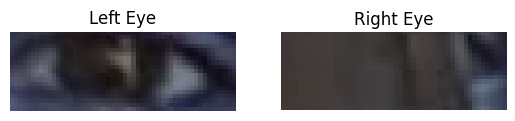

In [154]:
# Show the Cropped Eye Images
plt.subplot(1, 2, 1)
plt.imshow(left_eye_image)
plt.axis('off')
plt.title('Left Eye')

plt.subplot(1, 2, 2)
plt.imshow(right_eye_image)
plt.axis('off')
plt.title('Right Eye')

plt.show()

# Considering only the LEFT EYE AS OF NOW

In [155]:
def threshold_eye(eye):
    gray_roi = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)

    plt.subplot(1, 3, 1)
    plt.imshow(gray_roi)
    plt.title('Gray Frame')
    plt.axis('off')

    gray_roi = cv2.GaussianBlur(gray_roi, (11, 11), 0)

    plt.subplot(1, 3, 2)
    plt.imshow(gray_roi)
    plt.title('Guassian Blur')
    plt.axis('off')

    _, threshold = cv2.threshold(gray_roi, 40, 255, cv2.THRESH_BINARY_INV)

    plt.subplot(1, 3, 3)
    plt.imshow(threshold)
    plt.title('Threshold Image')
    plt.axis('off')

    plt.show()

    return threshold

In [156]:
def find_pupil(original_roi):
    """
    Find the pupil in the eye ROI
    :param original_roi: The original eye ROI
    """
    threshold_image = threshold_eye(original_roi)

    rows, cols, _ = original_roi.shape
    contours, hierarchy = cv2.findContours(threshold_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

    original_roi_copy = original_roi.copy()

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(original_roi_copy, (x, y), (x + w, y + h), (255, 0, 0), 1)
        cv2.line(original_roi_copy, (x + int(w/2), 0), (x + int(w/2), rows), (0, 255, 0), 1)
        cv2.line(original_roi_copy, (0, y + int(h/2)), (cols, y + int(h/2)), (0, 255, 0), 1)

        coordinates = {
            "center" : (x + int(w/2), y + int(h/2)),
            "radius" : int((w + h) / 4),
            "region_coordinates" : (x, y, x + w, y + h)
        }

        plt.subplot(1, 3, 1)
        plt.imshow(original_roi)
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(original_roi_copy)
        plt.title('Pupil Detection')

        plt.text(0, rows + 15, f'Shape - {rows, cols}', color='green')
        plt.text(cols, rows + 15, f'Pupil Position - {x + int(w/2), y + int(h/2)}', color='green')

        plt.subplot(1, 3, 3)
        plt.imshow(threshold_image)
        plt.title('Threshold Image')
        plt.show()

        return coordinates


In [ ]:
def validate_pupil(eyes_coordinates):
    """
    Validate the pupil coordinates
    :param eyes_coordinates: The coordinates of the eyes
    """
    left_eye_coordinates = eyes_coordinates['left']
    right_eye_coordinates = eyes_coordinates['right']

    left_eye_center = left_eye_coordinates['center']
    right_eye_center = right_eye_coordinates['center']

    left_eye_radius = left_eye_coordinates['radius']
    right_eye_radius = right_eye_coordinates['radius']

    if left_eye_center[0] > right_eye_center[0]:
        return False

    return True

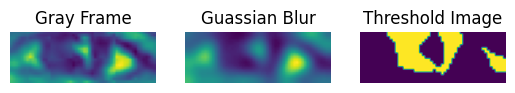

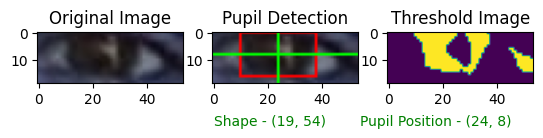

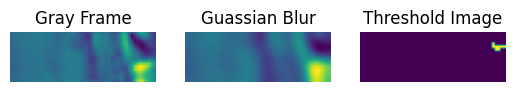

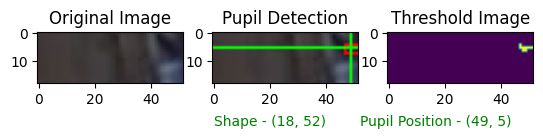

{'left': {'center': (24, 8), 'radius': 11, 'region_coordinates': (10, 0, 38, 16)}, 'right': {'center': (49, 5), 'radius': 2, 'region_coordinates': (47, 4, 52, 7)}}


In [160]:
pupil_coordinates = {
    'left': find_pupil(left_eye_image),
    'right': find_pupil(right_eye_image)
}

print(pupil_coordinates)

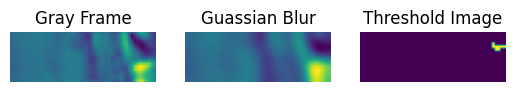

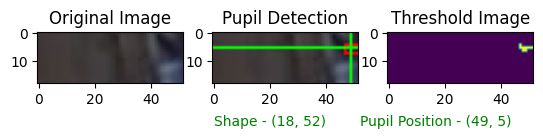

{'center': (49, 5), 'radius': 2, 'region_coordinates': (47, 4, 52, 7)}

## Using Contours

## Blob detection

In [8]:
# gray_frame = cv2.cvtColor(left_eye_image, cv2.COLOR_BGRA2GRAY)
# _, img = cv2.threshold(gray_frame, 42, 255, cv2.THRESH_BINARY)
#


In [9]:
# cv2.imshow('Frame', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.waitKey(1)

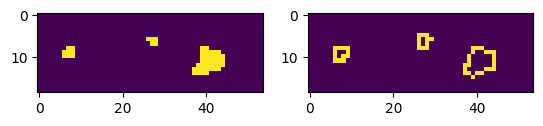

In [13]:

threshold1 = 30
threshold2 = 100
gray_frame = cv2.cvtColor(left_eye_image, cv2.COLOR_BGRA2GRAY)
_, img = cv2.threshold(gray_frame, 42, 255, cv2.THRESH_BINARY)

blurred_eye = cv2.GaussianBlur(gray_frame, (5, 5), 0)

edges = cv2.Canny(blurred_eye, threshold1, threshold2)
plt.subplot(1, 2, 1)
plt.imshow(edges)
# Contour analysis
# contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# plt.subplot(1, 2, 2)
# plt.imshow(contours)
plt.show()
# if contours:
#     largest_contour = max(contours, key=cv2.contourArea)
#
#     # Pupil detection
#     M = cv2.moments(largest_contour)
#     if M["m00"] != 0:
#         pupil_center_x = int(M["m10"] / M["m00"])
#         pupil_center_y = int(M["m01"] / M["m00"])
#         pupil_center = (pupil_center_x, pupil_center_y)
#
#         # Draw the pupil center on the original image
#         cv2.circle(img, pupil_center, radius=5, color=(0, 0, 255), thickness=-1)
#
# cv2.imshow("Detected Eye with Pupil", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [199]:
detector_params = cv2.SimpleBlobDetector_Params()
detector_params.filterByArea = True
# detector_params.maxArea = 1500
detector = cv2.SimpleBlobDetector_create(detector_params)

In [200]:
# def blob_process(img, detector):
#     gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     _, img = cv2.threshold(gray_frame, 42, 255, cv2.THRESH_BINARY)
#     keypoints = detector.detect(img)
#     return keypoints
# keypoints = blob_process(left_eye_image, detector)
# cv2.drawKeypoints(left_eye_image, keypoints, left_eye_image, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# cv2.imshow('Blobs', left_eye_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [204]:
def blob_process(img, threshold, detector):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
    img = cv2.erode(img, None, iterations=2)
    img = cv2.dilate(img, None, iterations=4)
    img = cv2.medianBlur(img, 5)
    keypoints = detector.detect(img)
    print(keypoints)
    return keypoints

In [205]:
blob_image = blob_process(left_eye_image, 42, detector)

()


TypeError: Invalid shape (0,) for image data

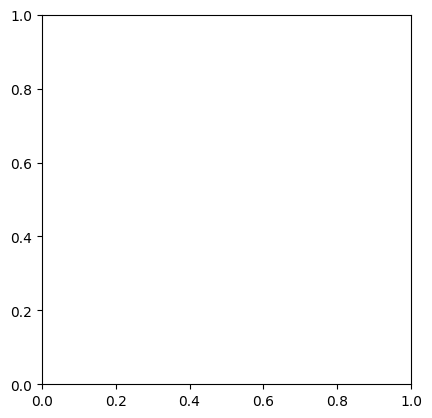

In [114]:
plt.imshow(blob_image)
plt.axis('off')
plt.title('blob_image')

plt.show()

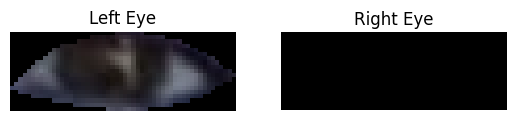

34.94411955815465
0.0
Left eye is not clearly visible
Right eye is not clearly visible


In [2]:


print(np.mean(left_eye_image))
print(np.mean(right_eye_image))

# Check if eyes are clearly visible
if np.mean(left_eye_image) > 50 and np.mean(left_eye_image) < 200:
    print("Left eye is clearly visible")
else:
    print("Left eye is not clearly visible")

if np.mean(right_eye_image) > 50 and np.mean(right_eye_image) < 200:
    print("Right eye is clearly visible")
else:
    print("Right eye is not clearly visible")


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_eyeball(eye_image):
    # Apply Gaussian blur to reduce noise
    # blurred_eye = cv2.GaussianBlur(eye_image, (9, 9), 2)

    # Apply the Hough Circle Transform to detect circles (eyeballs)
    circles = cv2.HoughCircles(
        eye_image,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,
        param2=30,
        minRadius=10,
        maxRadius=40
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]

            # Draw the circle
            cv2.circle(eye_image, center, radius, (0, 255, 0), 2)

            # Draw the center of the circle
            cv2.circle(eye_image, center, 2, (0, 0, 255), 3)

        # Display the result
        plt.imshow(cv2.cvtColor(eye_image, cv2.COLOR_BGR2RGB))
        plt.title("Detected Eyeball")
        plt.axis('off')
        plt.show()
    else:
        print("No eyeballs detected.")


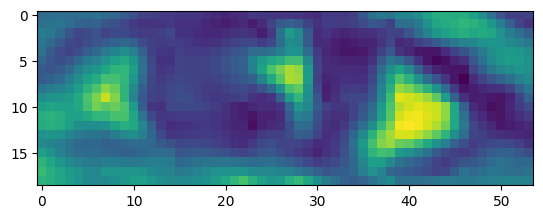

In [23]:

image_rgb = cv2.cvtColor(left_eye_image, cv2.COLOR_RGB2GRAY)
plt.imshow(image_rgb)
plt.show()

In [24]:
detect_eyeball(left_eye_image)
# detect_eyeball(right_eye_image)

error: OpenCV(4.8.0) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/hough.cpp:2269: error: (-215:Assertion failed) !_image.empty() && _image.type() == CV_8UC1 && (_image.isMat() || _image.isUMat()) in function 'HoughCircles'
